## notebook 03a: linear regression modelling of accuracy

In this notebook we read in the experiment result dataframe and set up a linear regression model that predicts the position error from the condition (number of objects) as a fixed effect and the participant ID as a random effect.
We motivate analysis steps and model choices at the respective locations in the notebook.

### 0) preparation

#### imports

In [59]:
library(moments) # for skewness and kurtosis test
library(lme4) # for linear mixed effects models
library(ggplot2) # for plotting
library(ggpubr) # for qq plot
library(lmtest) # for likelihood ratio test
library(jtools) # for nice regression outputs
require(car)

#### read in data

In [60]:
# read in experiment results data
separator = .Platform$file.sep
data_path = paste("..", separator, "data", separator, "processed_data.csv", sep="") 
save_path = paste("..", separator, "data", separator, sep="")

data_raw = read.csv(data_path, skip=0)

#### prepare datasets
We prepare two datasets. The first one "data" averages single trials within their respective session. In each condition, for each participant, there are four sessions. The second one "data_aggregated" averages single trials within their respective condition and participant identity. For each of six condition there are 23 averaged datapoints. All data are averaged by their median.
#### 1) prepare one dataset averaging along sessions

In [61]:
# average the position error across sessions by taking the median
position_error <- aggregate(data_raw$err_pos_walk , by = list(session_num=data_raw$session_num,
                            ppid=data_raw$ppid, condition=data_raw$num_objects), FUN = median)

# set up minimal dataframe
data <- data.frame(condition=position_error$condition, session_num=position_error$session_num,
                      ppid=position_error$ppid, err_pos_walk=position_error$x, 
                      num_objects=as.numeric(position_error$condition))

# set column types as desired
data$condition_ordinal <- as.ordered(data$condition)
data$condition_categorical <- as.factor(data$condition)
data$session_num <- as.ordered(data$session_num)
data$ppid<- as.factor(data$ppid)

#### 2) prepare another dataset averaging along conditions and participants

In [62]:
# average the position error by condition and ppid by taking the median
# this also removes dependencies in repetitions
position_error_aggregated <- aggregate(data_raw$err_pos_walk , by = list(ppid=data_raw$ppid,
                                           condition=data_raw$num_objects), FUN = median)
# set up minimal dataframe
data_aggregated <- data.frame(condition=position_error_aggregated$condition,
                                  ppid=position_error_aggregated$ppid, err_pos_walk=position_error_aggregated$x, 
                                  num_objects = as.numeric(position_error_aggregated$condition))

# set column types as desired
data_aggregated$condition_ordinal <- as.ordered(data_aggregated$condition)
data_aggregated$condition_categorical <- as.factor(data_aggregated$condition)
data_aggregated$ppid<- as.factor(data_aggregated$ppid)

### 1) visualise position error

#### 1.1) first dataset averaged along sessions

From visualising the position error for the first dataset (averaged along sessions), we learn that it is not normally distributed. This is not surprising as position error is zero-bounded. To satisfy assumptions of normality we log-transform the position error std data. The transformed distribution shows deviations from normality only at the tails. From plotting the order effect, meaning average position error across sessions, we observe a trend of improved performance over sessions. This is unsurprising, due to the constant nature of tree placement across conditions and trials and is further discussed in the paper.

[1] "Skewness untransformed: 1.944"
[1] "kurtosis untransformed: 7.536"


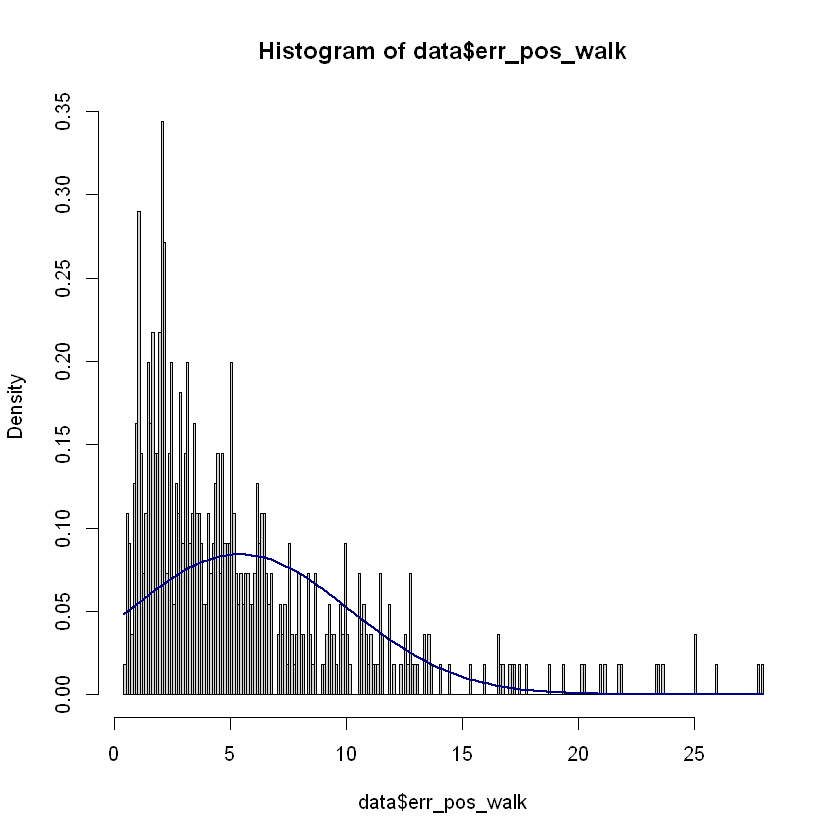

[1] "Skewness log-transformed: -0.054"
[1] "kurtosis log-transformed: 2.506"


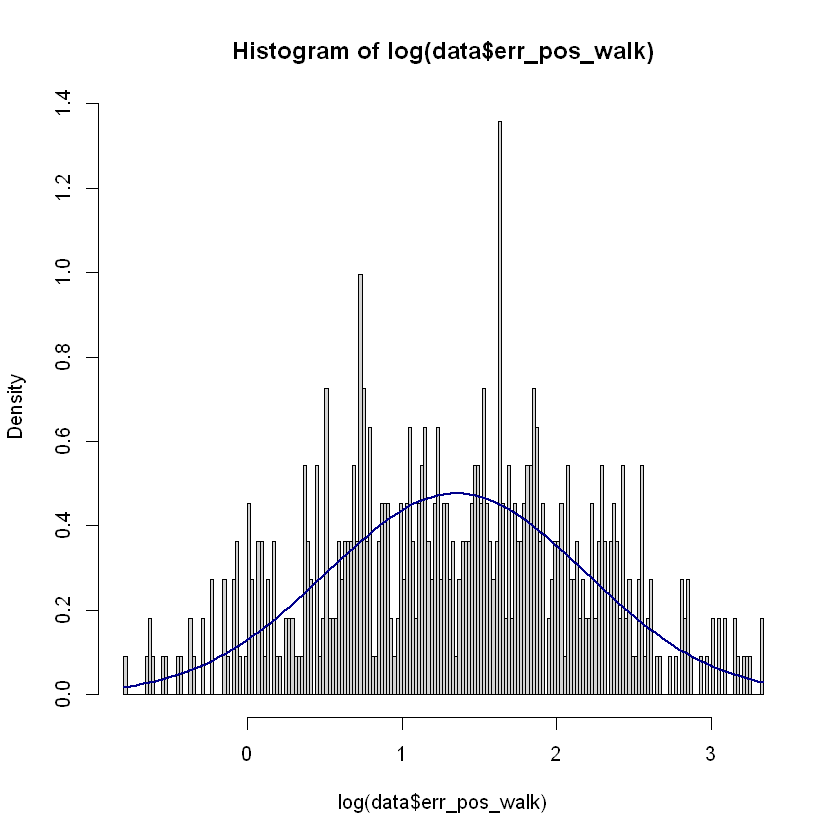


	Shapiro-Wilk normality test

data:  log(data$err_pos_walk)
W = 0.99416, p-value = 0.03239


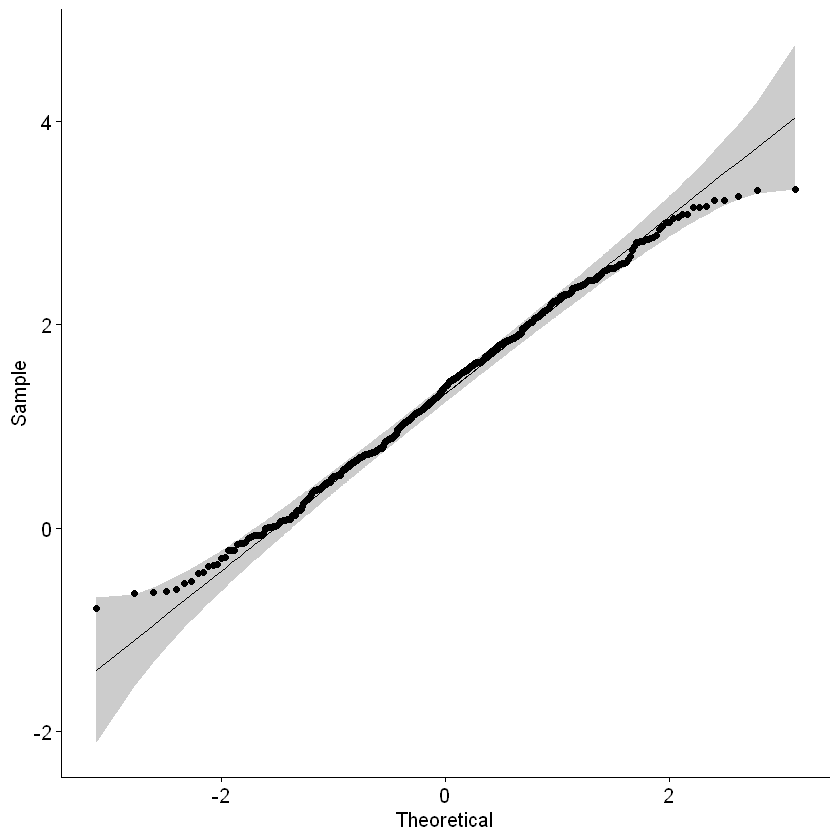

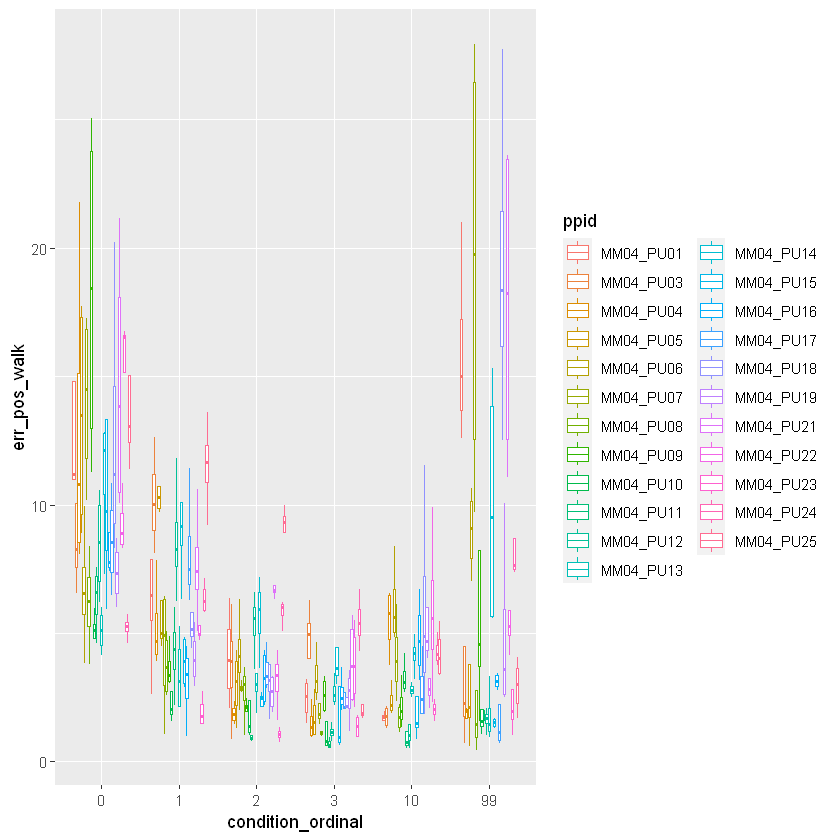

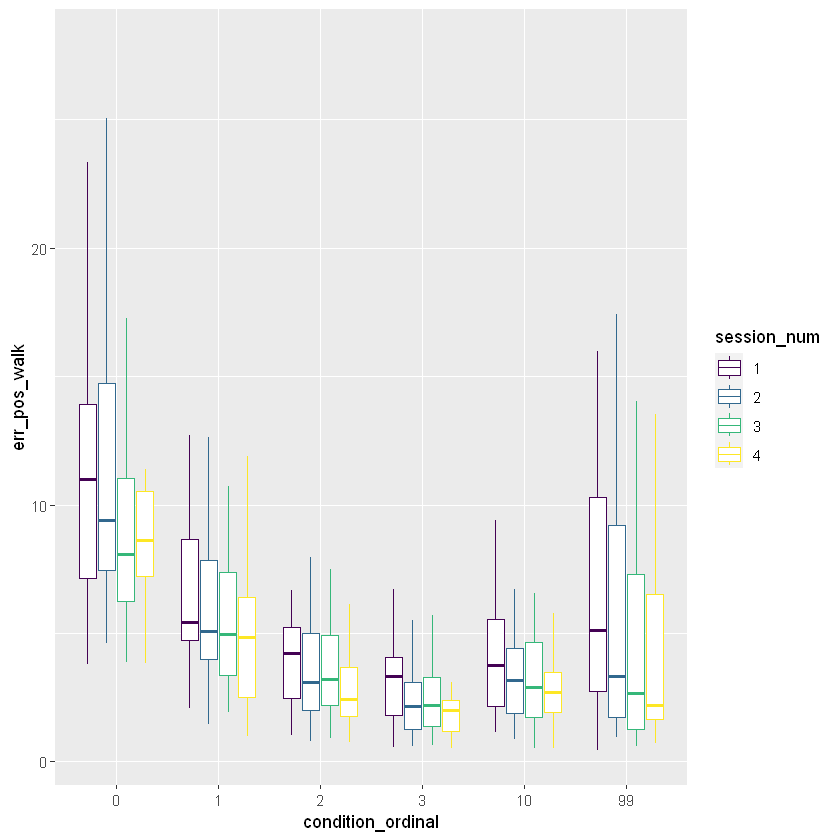

In [63]:
# histogram, skewness and kurtosis of untransformed data
hist(data$err_pos_walk, freq=FALSE, breaks=200)
curve(dnorm(x, mean=mean(data$err_pos_walk), sd=sd(data$err_pos_walk)), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")
print(paste("Skewness untransformed:", round(skewness(data$err_pos_walk),3)))
print(paste("kurtosis untransformed:", round(kurtosis(data$err_pos_walk),3)))

# histogram, skewness and kurtosis of log-transformed data
hist(log(data$err_pos_walk), freq=FALSE, breaks=200)
curve(dnorm(x, mean=mean(log(data$err_pos_walk)), sd=sd(log(data$err_pos_walk))), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")
print(paste("Skewness log-transformed:", round(skewness(log(data$err_pos_walk)),3)))
print(paste("kurtosis log-transformed:", round(kurtosis(log(data$err_pos_walk)),3)))

ggqqplot(log(data$err_pos_walk))

shapiro.test(log(data$err_pos_walk))

p <- ggplot(data, aes(x=condition_ordinal, y=err_pos_walk, color=ppid))
p + geom_boxplot(outlier.shape = NA, notch=FALSE) 

p2 <- ggplot(data, aes(x=condition_ordinal, y=err_pos_walk, color = session_num))
p2 + geom_boxplot(outlier.shape = NA, notch=FALSE) 

#### 1.2) second dataset averaged along conditions and participants

From visualising the position error for the second dataset (averaged along conditions and participants), we learn that it is not normally distributed either. This is not surprising as position error is zero-bounded. To satisfy assumptions of normality we log-transform the position error std data. The transformed distribution does not significantly differ from normality and the qqplot shows deviations from normality only at the tails.

[1] "Skewness untransformed: 1.644"
[1] "kurtosis untransformed: 5.821"


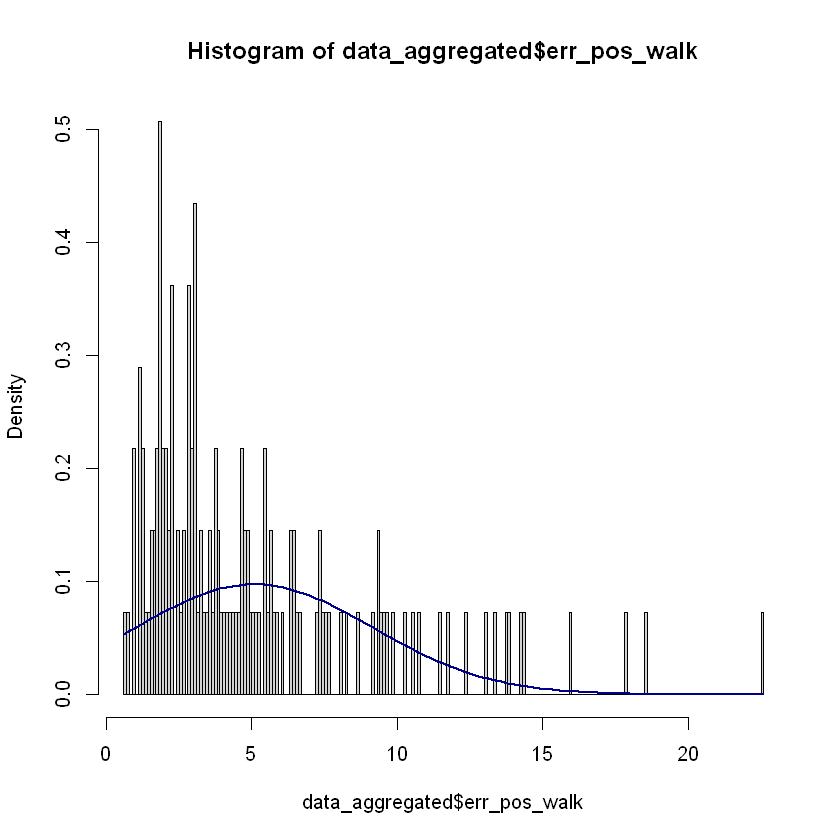

[1] "Skewness log-transformed: 0.081"
[1] "kurtosis log-transformed: 2.388"


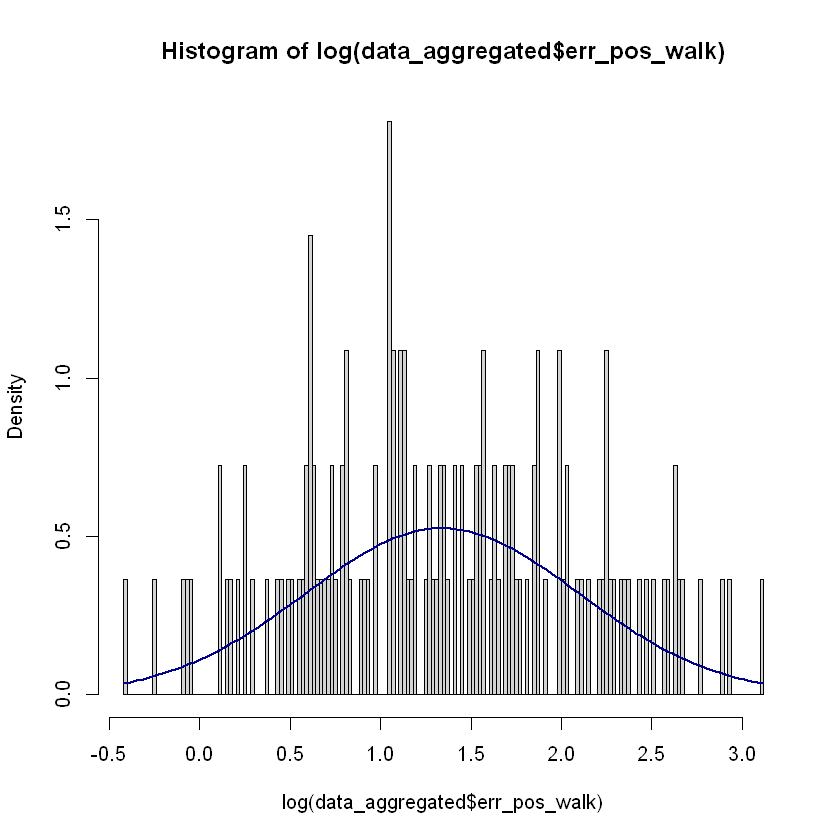


	Shapiro-Wilk normality test

data:  log(data_aggregated$err_pos_walk)
W = 0.9908, p-value = 0.5024


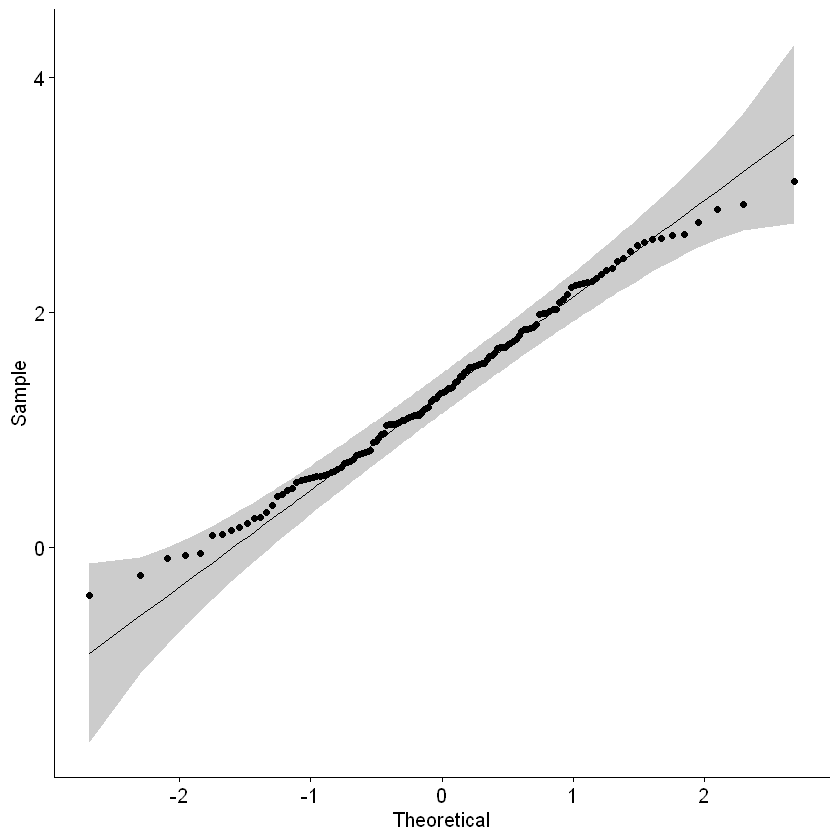

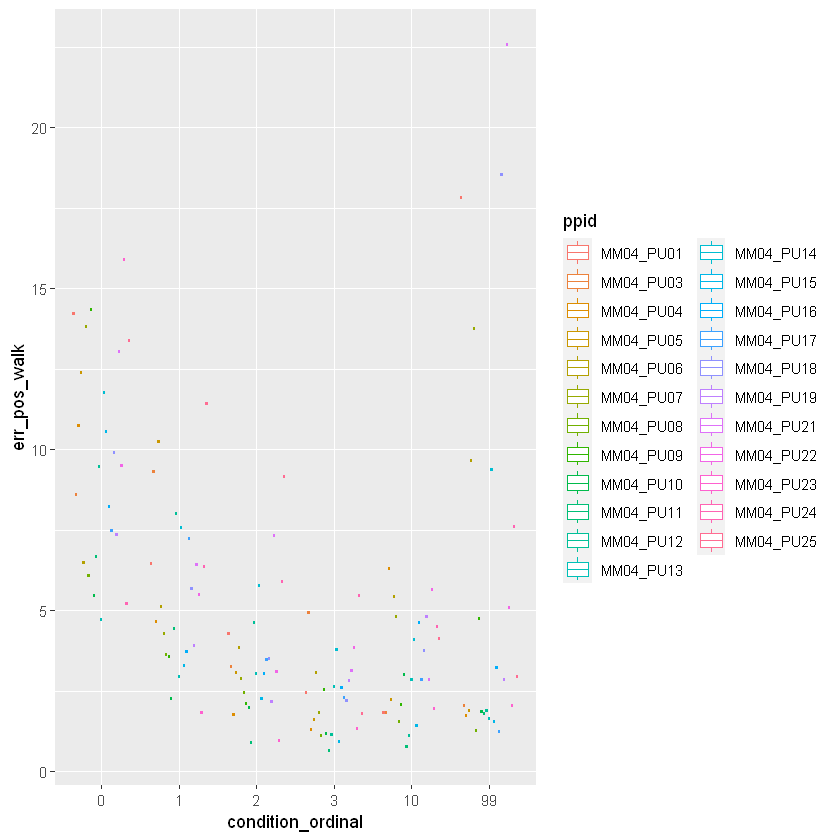

In [64]:
# histogram, skewness and kurtosis of untransformed data
hist(data_aggregated$err_pos_walk, freq=FALSE, breaks=200)
curve(dnorm(x, mean=mean(data_aggregated$err_pos_walk), sd=sd(data_aggregated$err_pos_walk)), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")
print(paste("Skewness untransformed:", round(skewness(data_aggregated$err_pos_walk),3)))
print(paste("kurtosis untransformed:", round(kurtosis(data_aggregated$err_pos_walk),3)))

# histogram, skewness and kurtosis of log-transformed data
hist(log(data_aggregated$err_pos_walk), freq=FALSE, breaks=200)
curve(dnorm(x, mean=mean(log(data_aggregated$err_pos_walk)), sd=sd(log(data_aggregated$err_pos_walk))), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")
print(paste("Skewness log-transformed:", round(skewness(log(data_aggregated$err_pos_walk)),3)))
print(paste("kurtosis log-transformed:", round(kurtosis(log(data_aggregated$err_pos_walk)),3)))

ggqqplot(log(data_aggregated$err_pos_walk))

shapiro.test(log(data_aggregated$err_pos_walk))

p <- ggplot(data_aggregated, aes(x=condition_ordinal, y=err_pos_walk, color=ppid))
p + geom_boxplot(outlier.shape = NA, notch=FALSE) 

### 2) set up linear mixed effects model

#### 2.1) compare regression model with and without order effect
We fit a model with ordinal condition as fixed factor and another model with an additional fixed effect of session and find the more complex model to fit only slightly better. As the order effect is small and not the primary focus of this study we do not consider it for our further analyses.

In [65]:
# set contrast coding to polynomial
contrasts(data$condition_ordinal) = contr.poly(6)
contrasts(data_aggregated$condition_ordinal) = contr.poly(6)

print("linear model containing fixed condition effect")
lm_condition_only <- lm(log(err_pos_walk) ~ condition_ordinal, data=data)
summary(lm_condition_only)

print("linear model containing fixed condition and fixed session effect")
lm_condition_and_session <- lm(log(err_pos_walk) ~ condition_ordinal + session_num, data=data)
summary(lm_condition_and_session)

print("AIC and BIC comparisons:")
print("fixed effect condition")
print(paste("AIC:",AIC(lm_condition_only), sep=""))
print(paste("BIC:",BIC(lm_condition_only), sep=""))
print("fixed effect condition + fixed effect session")
print(paste("AIC:",AIC(lm_condition_and_session), sep=""))
print(paste("BIC:",BIC(lm_condition_and_session), sep=""))
print("likelihood ratio tests:")
print("condition vs condition + session")
lrtest(lm_condition_only, lm_condition_and_session)

[1] "linear model containing fixed condition effect"



Call:
lm(formula = log(err_pos_walk) ~ condition_ordinal, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.12926 -0.45174  0.00762  0.46034  1.98575 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.34994    0.02933  46.023   <2e-16 ***
condition_ordinal.L -0.78125    0.07185 -10.874   <2e-16 ***
condition_ordinal.Q  0.85576    0.07185  11.911   <2e-16 ***
condition_ordinal.C  0.07141    0.07185   0.994   0.3207    
condition_ordinal^4 -0.13996    0.07185  -1.948   0.0519 .  
condition_ordinal^5 -0.09083    0.07185  -1.264   0.2067    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6891 on 546 degrees of freedom
Multiple R-squared:  0.328,	Adjusted R-squared:  0.3218 
F-statistic:  53.3 on 5 and 546 DF,  p-value: < 2.2e-16


[1] "linear model containing fixed condition and fixed session effect"



Call:
lm(formula = log(err_pos_walk) ~ condition_ordinal + session_num, 
    data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.30809 -0.43082  0.04582  0.42636  2.01102 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.349937   0.028921  46.676  < 2e-16 ***
condition_ordinal.L -0.781255   0.070843 -11.028  < 2e-16 ***
condition_ordinal.Q  0.855759   0.070843  12.080  < 2e-16 ***
condition_ordinal.C  0.071410   0.070843   1.008   0.3139    
condition_ordinal^4 -0.139964   0.070843  -1.976   0.0487 *  
condition_ordinal^5 -0.090830   0.070843  -1.282   0.2003    
session_num.L       -0.244322   0.057843  -4.224 2.82e-05 ***
session_num.Q        0.007723   0.057843   0.134   0.8938    
session_num.C       -0.049530   0.057843  -0.856   0.3922    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6795 on 543 degrees of freedom
Multiple R-squared:  0.3502,	Adjusted R-squa

[1] "AIC and BIC comparisons:"
[1] "fixed effect condition"
[1] "AIC:1163.43504261029"
[1] "BIC:1193.62987893423"
[1] "fixed effect condition + fixed effect session"
[1] "AIC:1150.85095599409"
[1] "BIC:1193.98643645686"
[1] "likelihood ratio tests:"
[1] "condition vs condition + session"


#Df LogLik    Df Chisq    Pr(>Chisq) 
1  7  -574.7175 NA       NA          NA
2 10  -565.4255  3 18.58409 0.000333234

#### 2.2) set up basic regression model with averaged dataset
To remove dependencies in single trial data, we average across trials and sessions using median position errors and continue our analysis with the second dataset "data_aggregated" (averaged along conditions and participants). We visually observe a clear effect of condition and suspect an influence of participant individuality, so we set up a model to quantify these effects. 

[1] "AIC: 730.407188153584"
[1] "BIC: 750.897963949684"
[1] " ############## SUMMARY ##############"


MODEL INFO:
Observations: 138
Dependent Variable: err_pos_walk
Type: OLS linear regression 

MODEL FIT:
F(5,132) = 15.22, p = 0.00
R² = 0.37
Adj. R² = 0.34 

Standard errors: OLS
--------------------------------------------------------
                             Est.   S.E.   t val.      p
------------------------- ------- ------ -------- ------
(Intercept)                  5.08   0.28    18.00   0.00
condition_ordinal.L         -3.26   0.69    -4.71   0.00
condition_ordinal.Q          5.06   0.69     7.32   0.00
condition_ordinal.C          0.12   0.69     0.18   0.86
condition_ordinal^4          0.22   0.69     0.32   0.75
condition_ordinal^5         -0.23   0.69    -0.33   0.74
--------------------------------------------------------

[1] " ############## RESIDUALS ##############"



	Shapiro-Wilk normality test

data:  residuals(lm_condition)
W = 0.87339, p-value = 1.701e-09


[1] " ############## HOMOSCEDASTICITY TEST ##############"


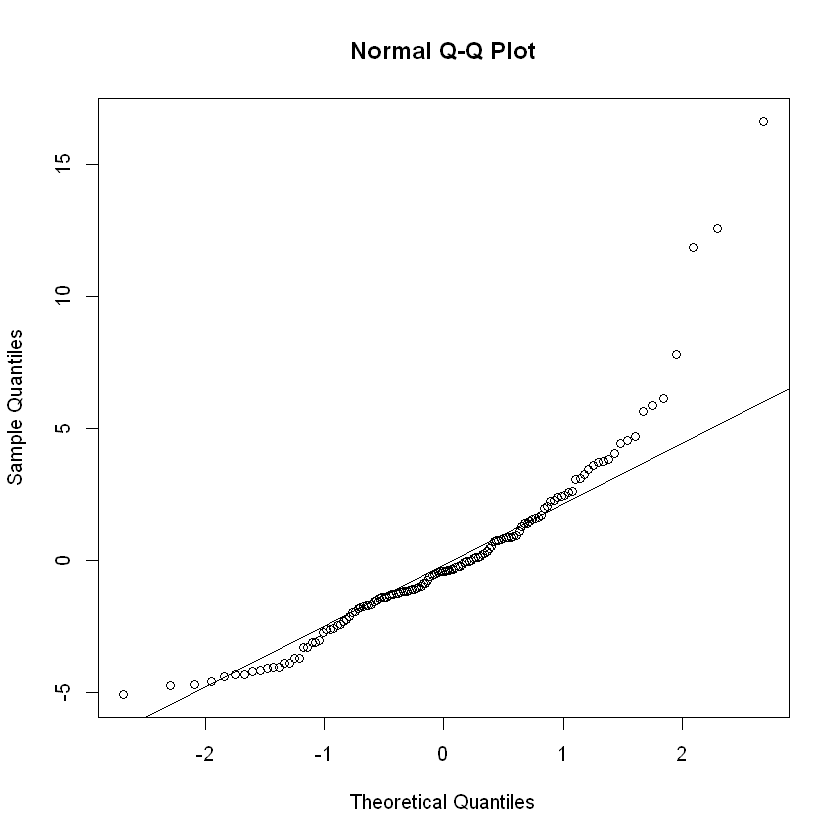

Df  F value  Pr(>F)      
group   5 4.885428 0.0003916582
      132       NA           NA

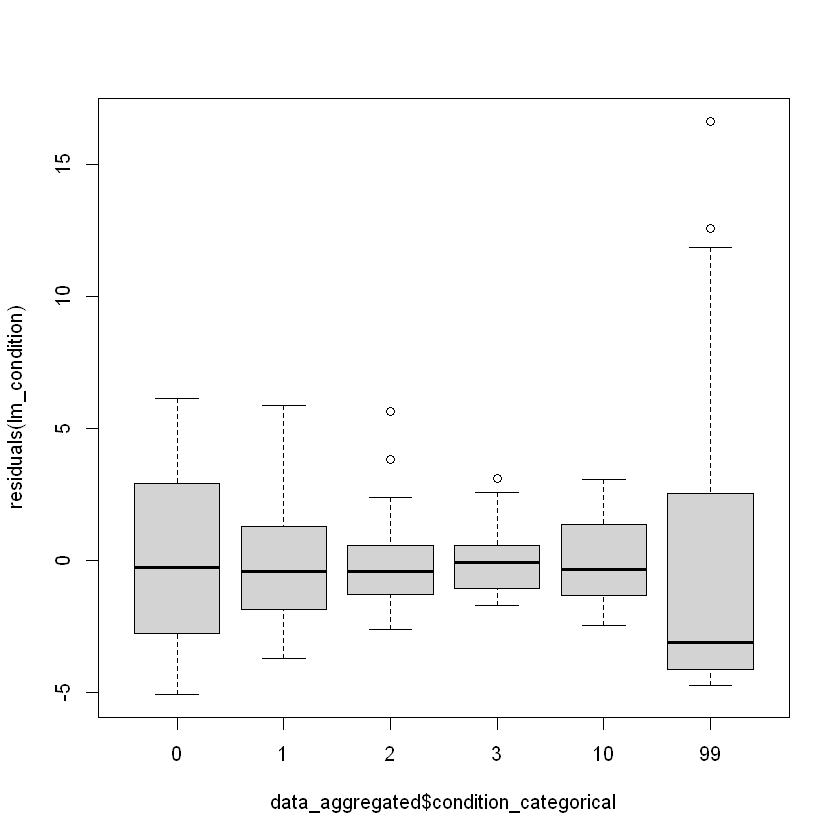

In [66]:
lm_condition <- lm(err_pos_walk ~ condition_ordinal, data=data_aggregated)
# print information criteria
print(paste("AIC: ", AIC(lm_condition), sep=""))
print(paste("BIC: ", BIC(lm_condition), sep=""))

# linear model summary and residuals
print(" ############## SUMMARY ##############")
summ(lm_condition)
print(" ############## RESIDUALS ##############")
qqnorm(residuals(lm_condition))
qqline(residuals(lm_condition))
shapiro.test(residuals(lm_condition))
print(" ############## HOMOSCEDASTICITY TEST ##############")
boxplot(residuals(lm_condition) ~ data_aggregated$condition_categorical)
leveneTest(residuals(lm_condition) ~ data_aggregated$condition_categorical)

We observe the model to fit the data rather badly as residuals are not normally distributed and heteroscedasticity is rather strong. Thus, we decide to log-transform position error and fit the model again.

#### 2.3) set up regression model with log-transformed data

[1] "AIC: 258.852184791618"
[1] "BIC: 279.342960587718"
[1] " ############## SUMMARY ##############"


MODEL INFO:
Observations: 138
Dependent Variable: log(err_pos_walk)
Type: OLS linear regression 

MODEL FIT:
F(5,132) = 17.37, p = 0.00
R² = 0.40
Adj. R² = 0.37 

Standard errors: OLS
--------------------------------------------------------
                             Est.   S.E.   t val.      p
------------------------- ------- ------ -------- ------
(Intercept)                  1.34   0.05    26.25   0.00
condition_ordinal.L         -0.79   0.13    -6.30   0.00
condition_ordinal.Q          0.84   0.13     6.69   0.00
condition_ordinal.C          0.08   0.13     0.63   0.53
condition_ordinal^4         -0.14   0.13    -1.09   0.28
condition_ordinal^5         -0.12   0.13    -0.93   0.35
--------------------------------------------------------

[1] " ############## RESIDUALS ##############"



	Shapiro-Wilk normality test

data:  residuals(lm_log_condition)
W = 0.98983, p-value = 0.413


[1] " ############## HOMOSCEDASTICITY TEST ##############"


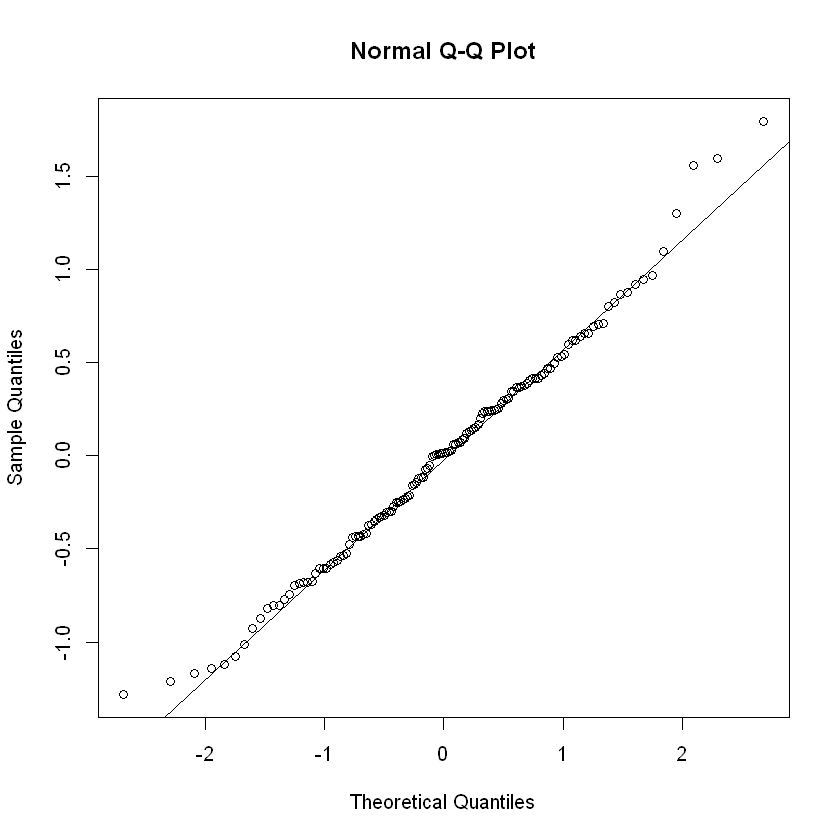

Df  F value  Pr(>F)      
group   5 4.449207 0.0008881948
      132       NA           NA

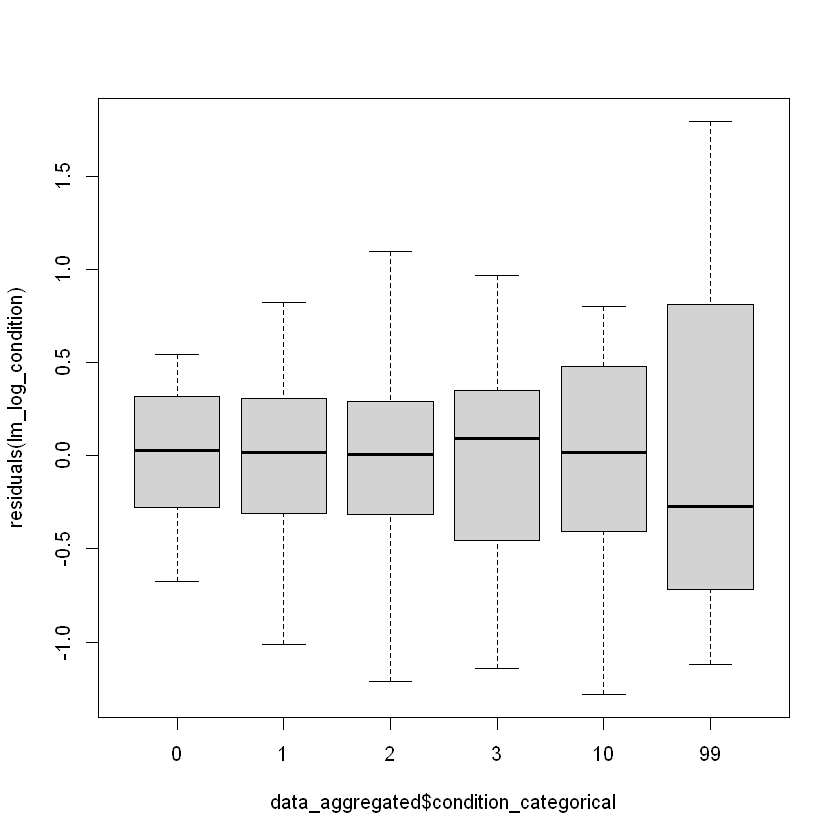

In [67]:
lm_log_condition <- lm(log(err_pos_walk) ~ condition_ordinal, data=data_aggregated)
# print information criteria
print(paste("AIC: ", AIC(lm_log_condition), sep=""))
print(paste("BIC: ", BIC(lm_log_condition), sep=""))

# linear model summary and residuals
print(" ############## SUMMARY ##############")
summ(lm_log_condition)
print(" ############## RESIDUALS ##############")
qqnorm(residuals(lm_log_condition))
qqline(residuals(lm_log_condition))
shapiro.test(residuals(lm_log_condition))
print(" ############## HOMOSCEDASTICITY TEST ##############")
boxplot(residuals(lm_log_condition) ~ data_aggregated$condition_categorical)
leveneTest(residuals(lm_log_condition) ~ data_aggregated$condition_categorical)

We observe the model with log-transformed position error to fit the data better as residuals are not significantly different from normality and heteroscedasticity, while still significant, is reduced. We decide to log-transform position error in further analyses.

#### 2.4) set up regression model including random participant effect

[1] "AIC: 239.001277934243"
[1] "BIC: 262.4193074155"
[1] " ############## SUMMARY ##############"


MODEL INFO:
Observations: 138
Dependent Variable: log(err_pos_walk)
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 239.00, BIC = 262.42
Pseudo-R² (fixed effects) = 0.40
Pseudo-R² (total) = 0.59 

FIXED EFFECTS:
-----------------------------------------------------------------
                             Est.   S.E.   t val.     d.f.      p
------------------------- ------- ------ -------- -------- ------
(Intercept)                  1.34   0.08    16.35    24.05   0.00
condition_ordinal.L         -0.79   0.10    -7.61   120.23   0.00
condition_ordinal.Q          0.84   0.10     8.09   120.23   0.00
condition_ordinal.C          0.08   0.10     0.76   120.23   0.45
condition_ordinal^4         -0.14   0.10    -1.31   120.23   0.19
condition_ordinal^5         -0.12   0.10    -1.13   120.23   0.26
-----------------------------------------------------------------

p values calculated using Kenward-Roger standard errors and
d.f.

RANDOM EFFECTS:
------------------------------------

[1] " ############## RESIDUALS ##############"



	Shapiro-Wilk normality test

data:  residuals(mm_condition_ppid)
W = 0.98052, p-value = 0.04585


[1] " ############## HOMOSCEDASTICITY TEST ##############"


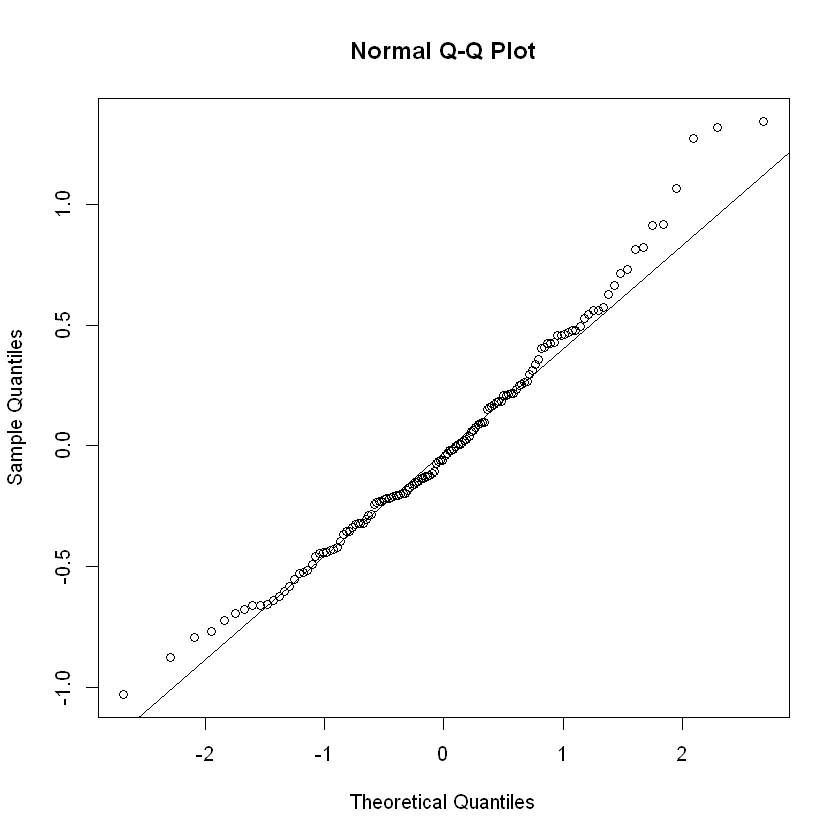

Df  F value  Pr(>F)     
group   5 3.174067 0.009722524
      132       NA          NA

[1] "comparison with and without random participant effect"


Warning message in modelUpdate(objects[[i - 1]], objects[[i]]):
"original model was of class "lmerMod", updated model is of class "lm""


#Df LogLik    Df Chisq    Pr(>Chisq)  
1 8   -111.5006 NA       NA           NA
2 7   -122.4261 -1 21.85091 2.946773e-06

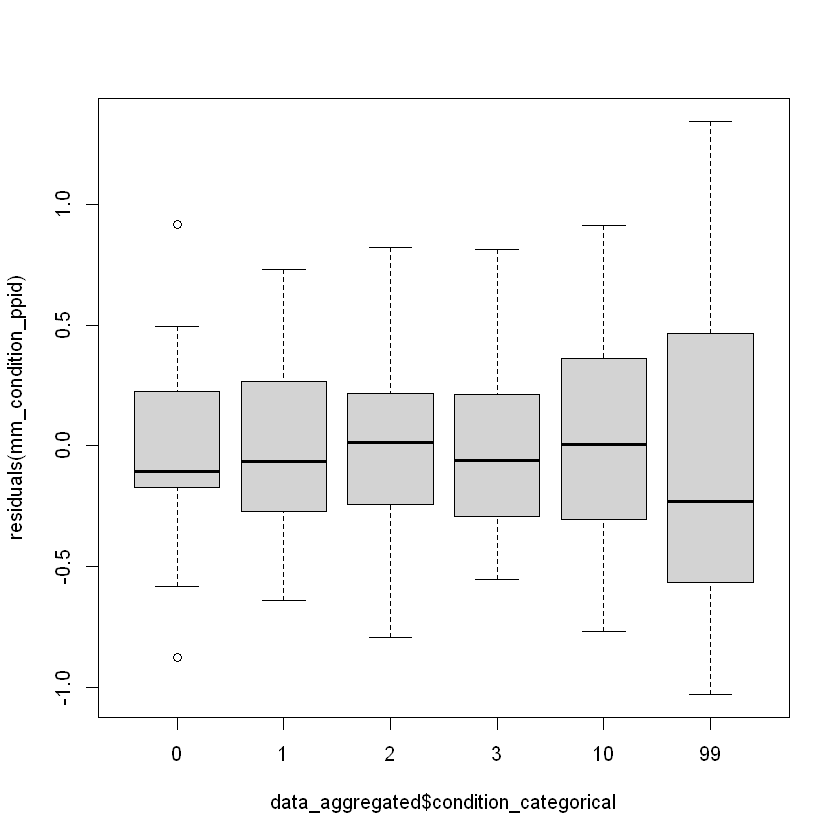

In [68]:
mm_condition_ppid <- lmer(log(err_pos_walk) ~ condition_ordinal + (1|ppid), data=data_aggregated, REML=FALSE)
# print information criteria
print(paste("AIC: ", AIC(mm_condition_ppid), sep=""))
print(paste("BIC: ", BIC(mm_condition_ppid), sep=""))

# linear model summary and residuals
print(" ############## SUMMARY ##############")
summ(mm_condition_ppid)
print(" ############## RESIDUALS ##############")
qqnorm(residuals(mm_condition_ppid))
qqline(residuals(mm_condition_ppid))
shapiro.test(residuals(mm_condition_ppid))
print(" ############## HOMOSCEDASTICITY TEST ##############")
boxplot(residuals(mm_condition_ppid) ~ data_aggregated$condition_categorical)
leveneTest(residuals(mm_condition_ppid) ~ data_aggregated$condition_categorical)

print("comparison with and without random participant effect")
lrtest(mm_condition_ppid, lm_log_condition)

Compared to the linear model without random participant effect, we find a significant improvement in information criteria AIC and BIC when adding the random effect of participant identity. However, we still have to consider the same heteroscedasticity of position errors between conditions, as well as slight deviations of the residuals from normality.

In [69]:
# print variances of groups
print(paste("variance within 0 object group:", round(var(data_aggregated[data_aggregated$num_objects==0,"err_pos_walk"]), 2)))
print(paste("variance within 1 object group:", round(var(data_aggregated[data_aggregated$num_objects==1,"err_pos_walk"]), 2)))
print(paste("variance within 2 object group:", round(var(data_aggregated[data_aggregated$num_objects==2,"err_pos_walk"]), 2)))
print(paste("variance within 3 object group:", round(var(data_aggregated[data_aggregated$num_objects==3,"err_pos_walk"]), 2)))
print(paste("variance within 10 object group:", round(var(data_aggregated[data_aggregated$num_objects==10,"err_pos_walk"]), 2)))
print(paste("variance within 99 object group:", round(var(data_aggregated[data_aggregated$num_objects==99,"err_pos_walk"]), 2)))

# calculate condition medians
condition_medians <- aggregate(log(data_aggregated$err_pos_walk) , by = list(condition = data_aggregated$condition_ordinal), FUN = median)
# define function to calculate residuals
pos_error_residual <- function(row)
{
    pos_error <- as.double(row["err_pos_walk"])
    condition_median_pos_error <- condition_medians[match(row["condition_ordinal"], unique(data_aggregated$condition_ordinal)), "x"]
    abs(pos_error - condition_median_pos_error)
}
# apply residual function to each row in data
data_aggregated$residuals <- apply(data_aggregated, 1, pos_error_residual)

# calculate ANOVA on residuals
levene.aov <- aov(residuals ~ condition_ordinal, data_aggregated)
summary(levene.aov)
# conduct post-hoc comparisons
TukeyHSD(levene.aov)

[1] "variance within 0 object group: 11.13"
[1] "variance within 1 object group: 6.38"
[1] "variance within 2 object group: 3.89"
[1] "variance within 3 object group: 1.59"
[1] "variance within 10 object group: 2.52"
[1] "variance within 99 object group: 40.49"


                   Df Sum Sq Mean Sq F value   Pr(>F)    
condition_ordinal   5  567.6  113.53   10.37 2.09e-08 ***
Residuals         132 1444.9   10.95                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = residuals ~ condition_ordinal, data = data_aggregated)

$condition_ordinal
            diff        lwr        upr     p adj
1-0   -3.6186658 -6.4401747 -0.7971568 0.0040580
2-0   -5.1168274 -7.9383363 -2.2953184 0.0000089
3-0   -5.9769795 -8.7984885 -3.1554706 0.0000001
10-0  -5.3402893 -8.1617983 -2.5187804 0.0000032
99-0  -2.6323862 -5.4538951  0.1891228 0.0824058
2-1   -1.4981616 -4.3196706  1.3233473 0.6420094
3-1   -2.3583138 -5.1798227  0.4631952 0.1578565
10-1  -1.7216236 -4.5431325  1.0998854 0.4920774
99-1   0.9862796 -1.8352294  3.8077885 0.9135857
3-2   -0.8601521 -3.6816611  1.9613568 0.9503022
10-2  -0.2234619 -3.0449709  2.5980470 0.9999119
99-2   2.4844412 -0.3370678  5.3059501 0.1183659
10-3   0.6366902 -2.1848187  3.4581992 0.9866078
99-3   3.3445933  0.5230844  6.1661023 0.0103079
99-10  2.7079031 -0.1136058  5.5294121 0.0678287


From a post-hoc analysis of the grouped variances we learn that most comparisons of the 0 object condition, and the 99 object condition with any other condition yield significant heteroscedasticity.

**heteroscedasticity in linear mixed models**:
Heteroscedasticity in linear mixed models does not cause large biases in coefficient estimates, however, it does make them less precise. Typically biases in fixed effects are <1%, and for group effects <2% even for "recognizably extreme" heteroscedastic datasets (Schielzeth et al., 2020).
Neither moderate heteroscedasticity nore moderate deviations of residuals from normality are considered major influences on linear mixed models (Schielzeth et al., 2020). However, we point out that interpretations on the raw coefficient estimates of this specific lme4 model and their p-values in particular might be imprecise.

References:

Schielzeth, H., Dingemanse, N. J., Nakagawa, S., Westneat, D. F., Allegue, H., Teplitsky, C., Réale, D., Dochtermann, N. A., Garamszegi, L. Z., Araya‐Ajoy, Y. G. (2020). Robustness of linear mixed‐effects models to violations of distributional assumptions. Methods in ecology and evolution, 11(9), 1141-1152.

As can be seen from the output of the same model but without the 99 object condition, deviations from normality as well as heteroscedasticity mainly come from the 99 object condition. This influence of the 99 object condition is part of our main finding. Thus, we decide to continue with fixed condition effect and random participant identity effect.

#### 2.5) linear mixed effects model without 99 object condition

[1] "AIC: 763.900266683444"
[1] "BIC: 792.818852109826"
[1] " ############## SUMMARY ##############"


MODEL INFO:
Observations: 460
Dependent Variable: log(err_pos_walk)
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 763.90, BIC = 792.82
Pseudo-R² (fixed effects) = 0.43
Pseudo-R² (total) = 0.59 

FIXED EFFECTS:
-----------------------------------------------------------------
                             Est.   S.E.   t val.     d.f.      p
------------------------- ------- ------ -------- -------- ------
(Intercept)                  1.35   0.07    19.41    22.00   0.00
condition_ordinal.L         -1.03   0.05   -19.34   433.00   0.00
condition_ordinal.Q          0.53   0.05    10.05   433.00   0.00
condition_ordinal.C          0.18   0.05     3.31   433.00   0.00
condition_ordinal^4          0.04   0.05     0.79   433.00   0.43
-----------------------------------------------------------------

p values calculated using Kenward-Roger standard errors and
d.f.

RANDOM EFFECTS:
------------------------------------
  Group      Parameter    Std. Dev. 
---------- ------------- ---

[1] " ############## RESIDUALS ##############"



	Shapiro-Wilk normality test

data:  residuals(mm_condition_ppid_wo99)
W = 0.99607, p-value = 0.3115


[1] " ############## HOMOSCEDASTICITY TEST ##############"


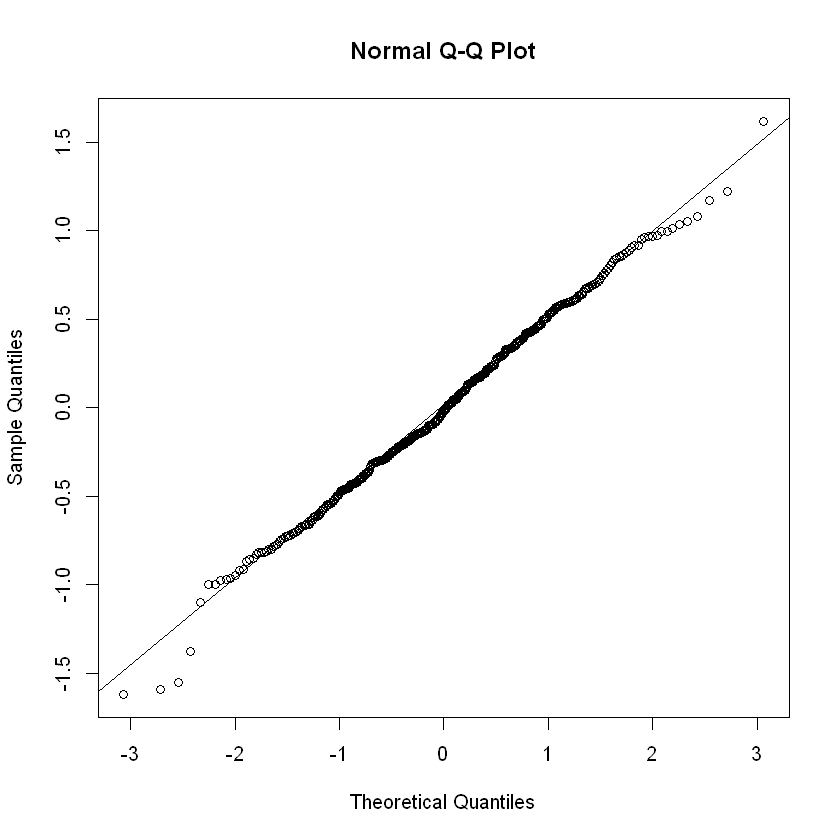

Df  F value   Pr(>F)   
group   4 0.9603495 0.4289846
      455        NA        NA

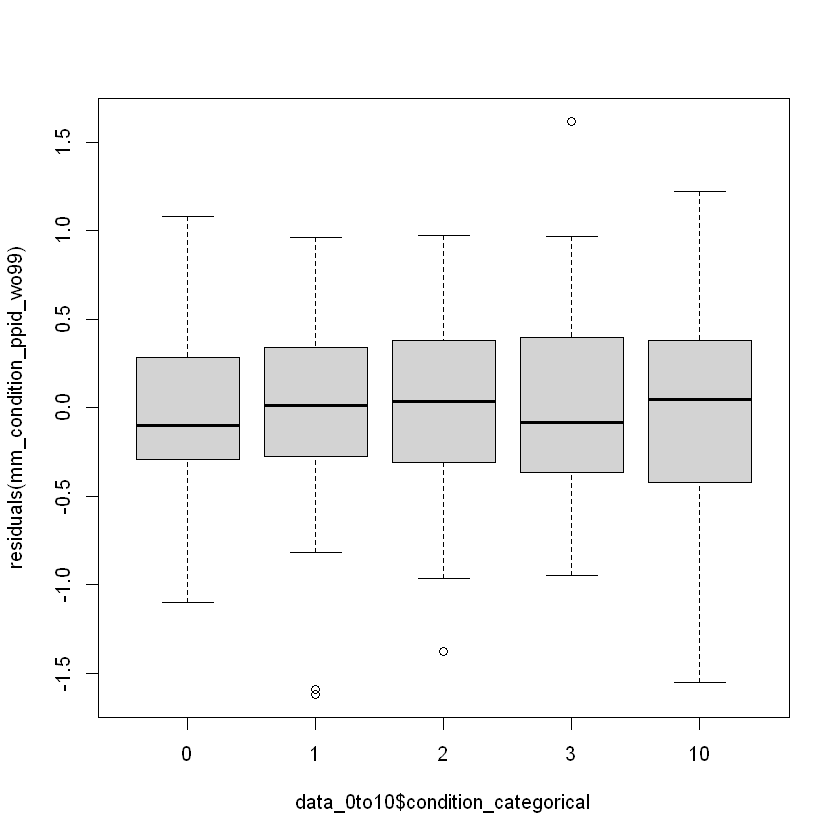

In [70]:
# make dataset without condition with 99 objects
data_0to10 <- data[data$num_objects!=99,]
data_0to10$condition_categorical <- droplevels(data_0to10$condition_categorical, c("99"))
data_0to10$condition_ordinal <- droplevels(data_0to10$condition_ordinal, c("99"))

mm_condition_ppid_wo99 <- lmer(log(err_pos_walk) ~ condition_ordinal + (1|ppid), data=data_0to10)
# print information criteria
print(paste("AIC: ", AIC(mm_condition_ppid_wo99), sep=""))
print(paste("BIC: ", BIC(mm_condition_ppid_wo99), sep=""))

# linear model summary and residuals
print(" ############## SUMMARY ##############")
summ(mm_condition_ppid_wo99)
print(" ############## RESIDUALS ##############")
qqnorm(residuals(mm_condition_ppid_wo99))
qqline(residuals(mm_condition_ppid_wo99))
shapiro.test(residuals(mm_condition_ppid_wo99))
print(" ############## HOMOSCEDASTICITY TEST ##############")
boxplot(residuals(mm_condition_ppid_wo99) ~ data_0to10$condition_categorical)
leveneTest(residuals(mm_condition_ppid_wo99) ~ data_0to10$condition_categorical)

### 3) motivate separation of effects
We visually observe a performance increase from 0 to 3 objects and a performance decrease from 3 to 99 objects. This pattern does not fit the assumptions of a linear fit. Additionally, we observe a significant linear and a significant quadratic term in our ordinal linear regression above (2.4). Here we present two analyses justifying a separation of the dataset into two effects:

#### 3.1) linear vs quadratic fit
From the model output above we learn that a linear but also a quadratic fit of the data are significantly well describing the data. We calculate the linear and quadratic fits from the mixed model above and learn that a quadratic fit does fit the data significantly better than a linear fit. The quadratic fit shows a local minimum close to the 3 object condition.

For convenience we plot the fits in logarithmic domain AND in regular domain, in which, however, the position error is zero-bounded. Please note that the x-axis does not show the number of objects in each condition, but the condition as an ordinal dimensionless variable. Therefore the local minimum position does not correspond to the one indicated in Figure 5. 

1 -> 0 objects / 2 -> 1 objects / 3 -> 2 objects / 4 -> 3 objects / 5 -> 10 objects / 6 -> 99 objects 

[1] "AIC linear: 293.017093692426"
[1] "BIC linear: 301.798854747897"
[1] "AIC quadratic: 255.38632172284"
[1] "BIC quadratic: 267.095336463469"


#Df LogLik    Df Chisq    Pr(>Chisq)  
1 3   -143.5085 NA       NA           NA
2 4   -123.6932  1 39.63077 3.068106e-10

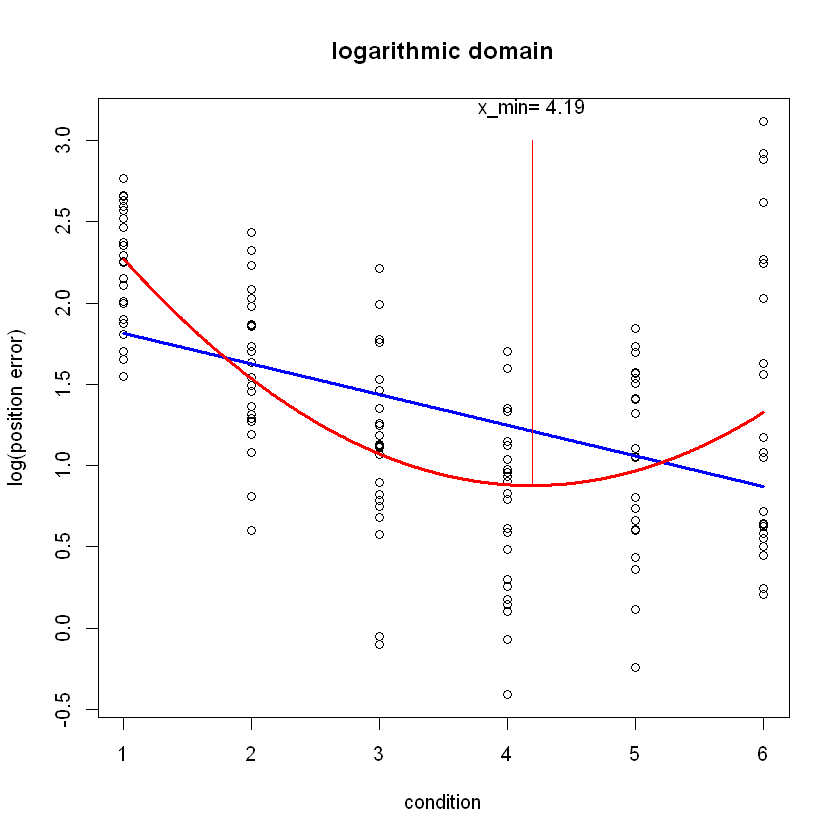

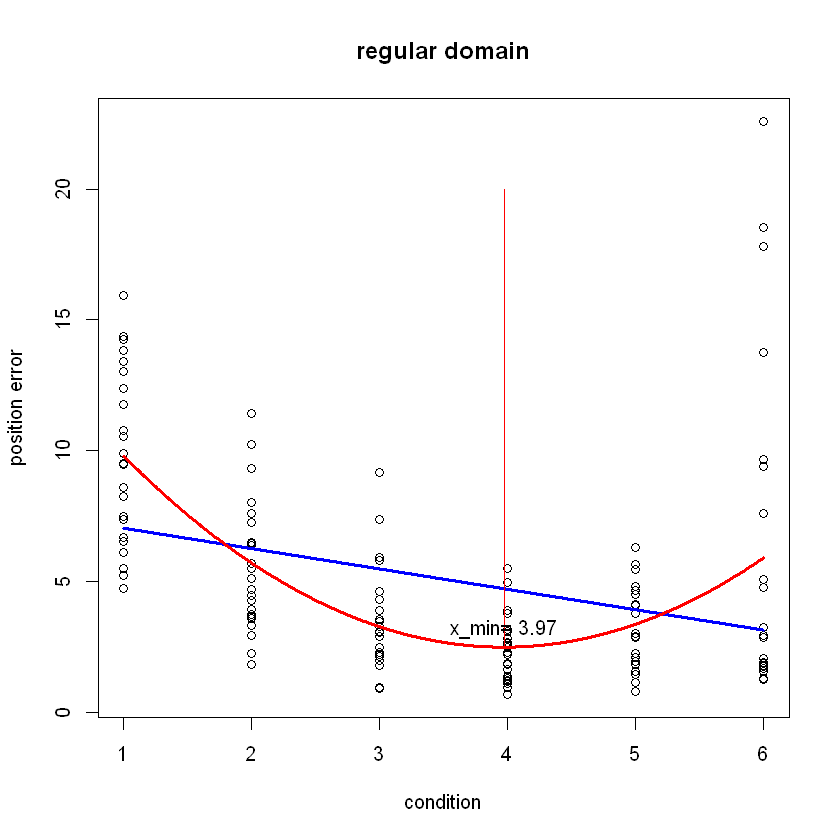

In [71]:
# fit a linear function to the position error
fit1 <- lm(log(data_aggregated$err_pos_walk) ~ poly(unclass(data_aggregated$condition_categorical),1,raw=TRUE))
fit1_no_log <- lm(data_aggregated$err_pos_walk ~ poly(unclass(data_aggregated$condition_categorical),1,raw=TRUE))
# fit a quadratic function to the position error
fit2 <- lm(log(data_aggregated$err_pos_walk) ~ poly(unclass(data_aggregated$condition_categorical),2,raw=TRUE))
fit2_no_log <- lm(data_aggregated$err_pos_walk ~ poly(unclass(data_aggregated$condition_categorical),2,raw=TRUE))
# define the x axis
x <- seq(min(unclass(data_aggregated$condition_categorical)), max(unclass(data_aggregated$condition_categorical)), length.out=1000)
# calculate the y-values for the linear and for the quadratic function
y1 <- fit1$coefficients[2]*x + fit1$coefficients[1]
y2 <- fit2$coefficients[3]*x^2 + fit2$coefficient[2]*x + fit2$coefficient[1]
y1_no_log <- fit1_no_log$coefficients[2]*x + fit1_no_log$coefficients[1]
y2_no_log <- fit2_no_log$coefficients[3]*x^2 + fit2_no_log$coefficient[2]*x + fit2_no_log$coefficient[1]
# find the local minimum of the quadratic fit
fit_min <- -fit2$coefficients[2]/(2*fit2$coefficients[3])
y_min <- fit2$coefficients[3]*fit_min^2 + fit2$coefficient[2]*fit_min + fit2$coefficient[1]
fit_min_no_log <- -fit2_no_log$coefficients[2]/(2*fit2_no_log$coefficients[3])
y_min_no_log <- fit2_no_log$coefficients[3]*fit_min_no_log^2 + fit2_no_log$coefficient[2]*fit_min_no_log + fit2_no_log$coefficient[1]

# compare the linear and the quadratic fit
print(paste("AIC linear: ", AIC(fit1), sep=""))
print(paste("BIC linear: ", BIC(fit1), sep=""))
print(paste("AIC quadratic: ", AIC(fit2), sep=""))
print(paste("BIC quadratic: ", BIC(fit2), sep=""))
lrtest(fit1,fit2)

# plot the log-transformed raw data together with the linear and the quadratic fit
plot(unclass(data_aggregated$condition_categorical), log(data_aggregated$err_pos_walk), xlab="condition", ylab="log(position error)", pch=1, main="logarithmic domain")
lines(x,y1, col="blue", lw=3)
lines(x,y2, col="red", lw=3)
lines(c(fit_min, fit_min),c(y_min,3),col="red")
text(fit_min, 3.2, paste("x_min=", round(fit_min,2)))

# plot the raw data together with the linear and the quadratic fit
plot(unclass(data_aggregated$condition_categorical), data_aggregated$err_pos_walk, xlab="condition", ylab="position error", pch=1, main="regular domain")
lines(x,y1_no_log, col="blue", lw=3)
lines(x,y2_no_log, col="red", lw=3)
lines(c(fit_min_no_log, fit_min_no_log),c(y_min_no_log,20),col="red")
text(fit_min_no_log, 3.2, paste("x_min=", round(fit_min_no_log,2)))

#### save confidence intervals of quadratic fit in csv file to plot them in python notebook nb_02

In [72]:
n_ppids <- length(unique(data_aggregated$ppid))
quadratic_fit_CIs <- predict(fit2, interval="confidence")[c(1,1+(1*n_ppids),1+(2*n_ppids),1+(3*n_ppids),1+(4*n_ppids),1+(5*n_ppids)),]
write.csv(quadratic_fit_CIs, paste(save_path, "quadratic_fit_CIs.csv", sep=""))

#### 3.2) forward difference coding
"In this coding system, the mean of the dependent variable for one level of the categorical variable is compared to the mean of the dependent variable for the next level." [contrast coding systems](https://stats.oarc.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/#forward)

Forward difference coding uses a coding matrix that allows to compare the central tendency of the dependent variable of each class with the subsequent class on the axis of the independent variable. Namely this means that the zero object condition is compared to the one object condition, which in turn is compared to the two object condition, and so on.

This approach results in negative estimates for the conditions with one, two and three objects and in positive estimates for ten and 99 objects. Again, we find a switch in the effect direction at the three object condition.

R Library Contrast Coding Systems For Categorical Variables. UCLA: Statistical Consulting Group. 
from https://stats.oarc.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/#forward (accessed December 20, 2022).

In [73]:
# setup forward difference coding contrast matrix
my.forward.diff = matrix(c(-5/6, 1/6, 1/6, 1/6, 1/6, 1/6, -4/6, -4/6, 2/6, 2/6, 2/6, 2/6, -3/6, -3/6, -3/6, 3/6, 3/6, 3/6, -2/6, -2/6, -2/6, -2/6, 4/6, 4/6, -1/6, -1/6, -1/6, -1/6, -1/6, 5/6), ncol = 5)
print("forward difference coding matrix:")
my.forward.diff

# set forward difference coding for ordinal condition
contrasts(data_aggregated$condition_ordinal) = my.forward.diff
# recalculate linear mixed model
mm_condition_and_ppid_aggregated_forward_difference <- lmer(log(err_pos_walk) ~ condition_ordinal + (1|ppid), data=data_aggregated, REML=FALSE)
print(" ############## SUMMARY ##############")
summ(mm_condition_and_ppid_aggregated_forward_difference)

[1] "forward difference coding matrix:"


[,1]       [,2]       [,3] [,4]       [,5]      
[1,] -0.8333333 -0.6666667 -0.5 -0.3333333 -0.1666667
[2,]  0.1666667 -0.6666667 -0.5 -0.3333333 -0.1666667
[3,]  0.1666667  0.3333333 -0.5 -0.3333333 -0.1666667
[4,]  0.1666667  0.3333333  0.5 -0.3333333 -0.1666667
[5,]  0.1666667  0.3333333  0.5  0.6666667 -0.1666667
[6,]  0.1666667  0.3333333  0.5  0.6666667  0.8333333

[1] " ############## SUMMARY ##############"


MODEL INFO:
Observations: 138
Dependent Variable: log(err_pos_walk)
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 239.00, BIC = 262.42
Pseudo-R² (fixed effects) = 0.40
Pseudo-R² (total) = 0.59 

FIXED EFFECTS:
----------------------------------------------------------------
                            Est.   S.E.   t val.     d.f.      p
------------------------ ------- ------ -------- -------- ------
(Intercept)                 1.34   0.08    16.35    24.05   0.00
condition_ordinal1         -0.61   0.15    -4.15   120.23   0.00
condition_ordinal2         -0.50   0.15    -3.40   120.23   0.00
condition_ordinal3         -0.38   0.15    -2.61   120.23   0.01
condition_ordinal4          0.31   0.15     2.10   120.23   0.04
condition_ordinal5          0.28   0.15     1.93   120.23   0.06
----------------------------------------------------------------

p values calculated using Kenward-Roger standard errors and
d.f.

RANDOM EFFECTS:
------------------------------------
  Group  

Both analyses, the quadratic fit approach and the forward difference coding approach, yield the conclusion that position error decreases from 0 to 3 objects, and increases from 3 to 99 objects. Thus, we...

#### 3.3) generate separated datasets on single trial basis

In [74]:
# set up minimal dataframe
data <- data.frame(condition=data_raw$num_objects, session_num=data_raw$session_num,
                      ppid=data_raw$ppid, err_pos_walk=data_raw$err_pos_walk, 
                      num_objects=as.numeric(data_raw$num_objects))

# set column types as desired
data$condition_ordinal <- as.ordered(data$condition)
data$condition_categorical <- as.factor(data$condition)
data$session_num <- as.ordered(data$session_num)
data$ppid<- as.factor(data$ppid)

# generate separate dataset for 0-3 objects
data_0to3 <- data[data$num_objects<=3,]
# we also need to drop the categorical level explicitely
data_0to3$condition_categorical <- droplevels(data_0to3$condition_categorical, c("10","99"))
data_0to3$condition_ordinal <- droplevels(data_0to3$condition_ordinal, c("10","99"))
# generate separate dataset for 3-99 objects
data_3to99 <- data[data$num_objects>=3,]
# we also need to drop the categorical level explicitely
data_3to99$condition_categorical <- droplevels(data_3to99$condition_categorical, c("0","1","2"))
data_3to99$condition_ordinal <- droplevels(data_3to99$condition_ordinal, c("0","1","2"))

### 4) separation of effects
To further investigate individual and condition effects, we separate our dataset into an effect from zero to three objects and an effect from three to 99 objects. 

We describe the shape of performance change with differing object counts on individual level in regular, not in logarithmic domain anymore. We calculate the difference between the zero and three object condition as well as between the three and 99 objects condition for each participant.

We plot kernel density estimations and compare the two distributions zero to three and three to 99 objects in the next jupyter notebook (nb_04a_condition_and_individuality_median_differences_accuracy).

### save median differences

In [75]:
# set up array to save median differences
diff_0to3 <- numeric()
diff_3to99 <- numeric()

for (participant in unique(data$ppid)){
    # extract participant data
    ppid_dat_0to3 <- data_0to3[data_0to3$ppid==participant,]
    # calculate diff between 0 and 3 objects
    ppid_0_median <- median(ppid_dat_0to3[ppid_dat_0to3$num_objects==0, "err_pos_walk"])
    ppid_3_median <- median(ppid_dat_0to3[ppid_dat_0to3$num_objects==3, "err_pos_walk"])
    ppid_diff_0to3 <- ppid_3_median - ppid_0_median
    diff_0to3 <- c(diff_0to3, ppid_diff_0to3)
    
    # extract participant data
    ppid_dat_3to99 <- data_3to99[data_3to99$ppid==participant,]  
    # calculate diff between 3 and 99 objects
    ppid_99_median <- median(ppid_dat_3to99[ppid_dat_3to99$num_objects==99, "err_pos_walk"])
    ppid_diff_3to99 <- ppid_99_median - ppid_3_median
    diff_3to99 <- c(diff_3to99, ppid_diff_3to99)
}

diffs_df <- data.frame(unique(data$ppid), diff_0to3, diff_3to99)
write.csv(diffs_df, paste(save_path, "diffs.csv", sep=""))

### save median differences for session 1 and session 4 only

In [76]:
############# only for session 1 ################
# set up array to save median differences but only for session 1
diff_0to3 <- numeric()
diff_3to99 <- numeric()

for (participant in unique(data$ppid)){
    # extract participant data
    ppid_dat_0to3 <- data_0to3[(data_0to3$ppid==participant) & (data_0to3$session_num==1),]
    # calculate diff between 0 and 3 objects
    ppid_0_median <- median(ppid_dat_0to3[ppid_dat_0to3$num_objects==0, "err_pos_walk"])
    ppid_3_median <- median(ppid_dat_0to3[ppid_dat_0to3$num_objects==3, "err_pos_walk"])
    ppid_diff_0to3 <- ppid_3_median - ppid_0_median
    diff_0to3 <- c(diff_0to3, ppid_diff_0to3)
    
    # extract participant data
    ppid_dat_3to99 <- data_3to99[(data_3to99$ppid==participant) & (data_3to99$session_num==1),]  
    # calculate diff between 3 and 99 objects
    ppid_99_median <- median(ppid_dat_3to99[ppid_dat_3to99$num_objects==99, "err_pos_walk"])
    ppid_diff_3to99 <- ppid_99_median - ppid_3_median
    diff_3to99 <- c(diff_3to99, ppid_diff_3to99)
}

diffs_df <- data.frame(unique(data$ppid), diff_0to3, diff_3to99)
write.csv(diffs_df, paste(save_path, "diffs_only_session1.csv", sep=""))

############# only for session 4 ################
# set up array to save median differences but only for session 1
diff_0to3 <- numeric()
diff_3to99 <- numeric()

for (participant in unique(data$ppid)){
    # extract participant data
    ppid_dat_0to3 <- data_0to3[(data_0to3$ppid==participant) & (data_0to3$session_num==4),]
    # calculate diff between 0 and 3 objects
    ppid_0_median <- median(ppid_dat_0to3[ppid_dat_0to3$num_objects==0, "err_pos_walk"])
    ppid_3_median <- median(ppid_dat_0to3[ppid_dat_0to3$num_objects==3, "err_pos_walk"])
    ppid_diff_0to3 <- ppid_3_median - ppid_0_median
    diff_0to3 <- c(diff_0to3, ppid_diff_0to3)
    
    # extract participant data
    ppid_dat_3to99 <- data_3to99[(data_3to99$ppid==participant) & (data_3to99$session_num==4),]  
    # calculate diff between 3 and 99 objects
    ppid_99_median <- median(ppid_dat_3to99[ppid_dat_3to99$num_objects==99, "err_pos_walk"])
    ppid_diff_3to99 <- ppid_99_median - ppid_3_median
    diff_3to99 <- c(diff_3to99, ppid_diff_3to99)
}

diffs_df <- data.frame(unique(data$ppid), diff_0to3, diff_3to99)
write.csv(diffs_df, paste(save_path, "diffs_only_session4.csv", sep=""))